In [8]:
import random
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA # pip install scikit-learn
from sksurv.nonparametric import kaplan_meier_estimator # pip install scikit-survival
import matplotlib.pyplot as plt
from seaborn import heatmap, histplot

In [9]:
survival_data = pd.read_csv('METABRIC_RNA_Mutation.csv')
# Get a list of columns and their indices
columns_indices = pd.DataFrame(survival_data.columns, columns=['column_name'])
columns_indices

/var/folders/3x/f8j9tddj7flfxt9zx1gkws1m0000gn/T/ipykernel_64036/3962743360.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  survival_data = pd.read_csv('METABRIC_RNA_Mutation.csv')


,column_name
0,patient_id
1,age_at_diagnosis
2,type_of_breast_surgery
3,cancer_type
4,cancer_type_detailed
...,...
688,hras_mut
689,prps2_mut
690,smarcb1_mut
691,stmn2_mut


In [10]:
metadata = survival_data.iloc[:, :31]
# The genetics part of the dataset contains m-RNA levels z-score for 331 genes, and mutation for 175 genes.
# z-score z = (expression in tumor sample - mean expression in reference sample) / standard deviation of expression in reference sample
gex_data = survival_data.iloc[:, 31:520]
mut_data = survival_data.iloc[:, 520:]

<Axes: xlabel='overall_survival_months', ylabel='Count'>

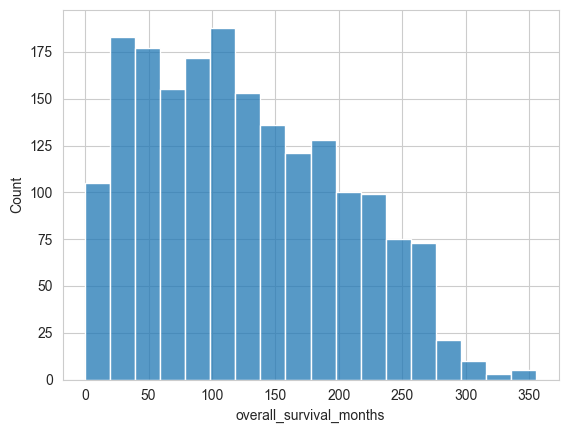

In [11]:
histplot(data=metadata, x='overall_survival_months')

In [12]:
# make random gene panel
random.seed(1234)
random_indices = random.sample(range(len(gex_data.columns)), 20)
# generate X
X = gex_data.iloc[:, random_indices]

In [17]:
# TODO: compute PCA of X -> change this array
X_pca = np.random.rand(X.shape[0], 2) - 0.5

<Axes: ylabel='Count'>

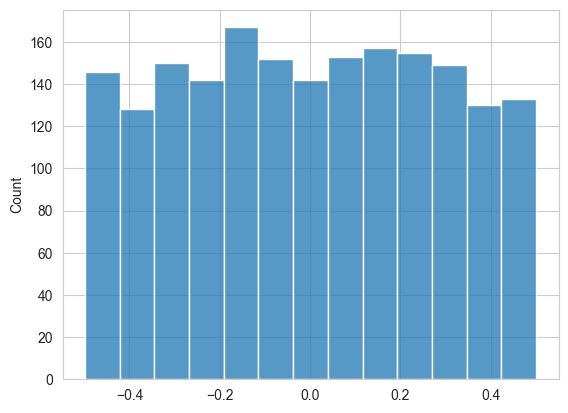

In [18]:
# plot first component of PCA as histogram
histplot(X_pca[:, 0])

In [19]:
# split data into 2 classes: PCA component 1 < 0 and PCA component 1 >= 0; extract only the indices
mask_group1 = X_pca[:, 0] < 0
# prepare y: first column: overall_survival (as boolean), second column: overall_survival_months
y = pd.DataFrame({'Status': pd.Series(metadata['overall_survival']).astype(bool), 
                  'Survival_in_months': metadata['overall_survival_months']})

Text(0.5, 1.0, 'group2')

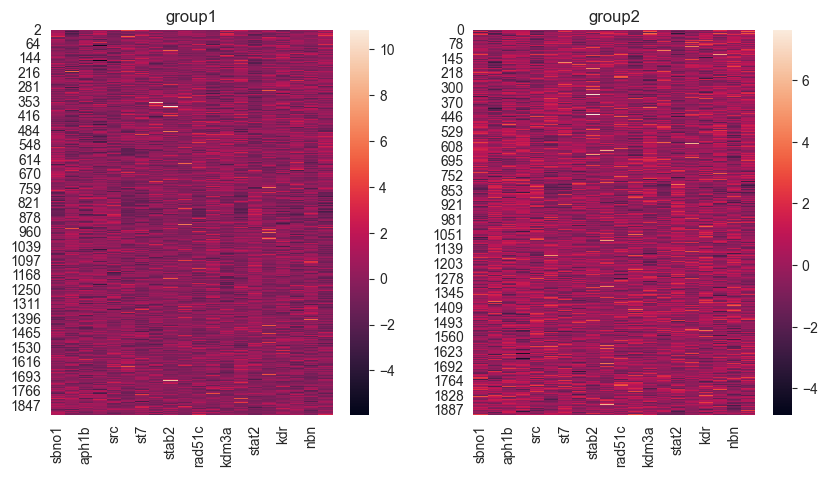

In [20]:
# plot heatmap of gene expression for expression of genes in random gene panel, split by group
# two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# group1
heatmap(data=X[mask_group1], ax=axs[0])
axs[0].set_title("group1")
# group2
heatmap(data=X[~mask_group1], ax=axs[1])
axs[1].set_title("group2")

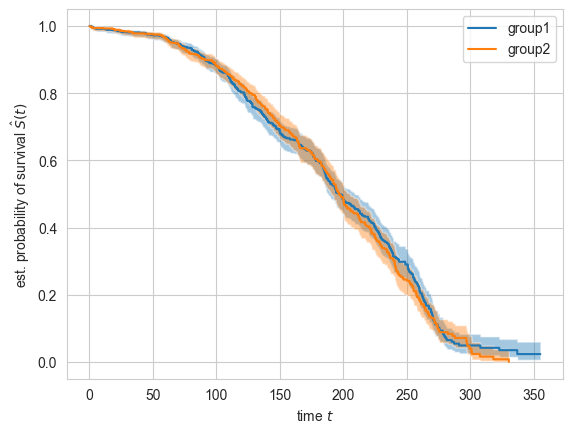

In [21]:
# Kaplan-Meier estimator
for group in ("group1", "group2"):
    mask_km = mask_group1 if group == "group1" else ~mask_group1
    time, survival_prob, conf_int = kaplan_meier_estimator(y['Status'][mask_km],
    y['Survival_in_months'][mask_km], conf_type="log-log")
    plt.step(time, survival_prob, where="post", label=f"{group}")
    plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.4, step="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend()

In [22]:
# log-rank test
import numpy as np
from sksurv.compare import compare_survival
# make numpy array of tuples from y. First element of tuple is Status, second element is Survival_in_months
y_np = np.array(list(zip(y['Status'], y['Survival_in_months'])), dtype=[('Status', bool), ('Survival_in_months', float)])
# group membership: if mask_group1 is True, then group1, else group2
group_membership = np.array(["group1" if mask_group1[i] else "group2" for i in range(len(mask_group1))])
chisq, pvalue, stats, covariance = compare_survival(y_np, group_membership, return_stats=True)
print(f"chi-squared: {chisq}")
print(f"p-value: {pvalue}")
print(f"stats: {stats}")
print(f"covariance: {covariance}")

chi-squared: 0.17036598739618414
p-value: 0.6797867477633419
stats:         counts  observed    expected  statistic
group                                          
group1     958       409  414.824895  -5.824895
group2     946       392  386.175105   5.824895
covariance: [[ 199.15595141 -199.15595141]
 [-199.15595141  199.15595141]]
